In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import matplotlib.pyplot as plt

In [21]:
df = pd.read_csv("dataset_finalized.csv",index_col=0)
df = df.sample(frac = 1)

In [22]:
df = df.iloc[0:14063, :]
df['classification'] = df['classification'].map({'left': 0, 'right': 1})
df

,text,classification
12021,The 'in'justice system in the U.S. is broken. ...,0
4132,"Alright, a bunch of things for me to unpack:",0
23929,Anyone else think you could blindfold Morning ...,1
27413,"""Did You Not Prepare for This Hearing?"" - Sen....",1
8566,No one but the completely bought in are believ...,0
...,...,...
25508,Sit her fat stinky ass in front of a TV and ha...,1
6173,"Biden is, just getting the due diligence part ...",0
14800,A sitting President has never lost an election...,1
2775,Should be everyone’s religion in a country tha...,0


In [23]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

loading file https://huggingface.co/bert-base-uncased/resolve/main/vocab.txt from cache at C:\Users\Thanat M/.cache\huggingface\transformers\45c3f7a79a80e1cf0a489e5c62b43f173c15db47864303a55d623bb3c96f72a5.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/bert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer_config.json from cache at C:\Users\Thanat M/.cache\huggingface\transformers\c1d7f0a763fb63861cc08553866f1fc3e5a6f4f07621be277452d26d71303b7e.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading file https://huggingface.co/bert-base-uncased/resolve/main/tokenizer.json from cache at C:\Users\Thanat M/.cache\huggingface\transformers\534479488c54aeaf9c3406f647aa2ec13648c06771ffe269edabebd4c412da1d.7f2721073f19841be16f4

In [24]:
X = list(df["text"])
y = list(df["classification"])
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
X_train_tokenized = tokenizer(X_train, padding = True, truncation = True, max_length = 50)
X_val_tokenized = tokenizer(X_val, padding = True, truncation = True, max_length = 50)


In [25]:
# create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [26]:
train_dataset = Dataset(X_train_tokenized, y_train)
val_dataset = Dataset(X_val_tokenized, y_val)

In [27]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)

    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    recall = recall_score(y_true=labels, y_pred=pred)
    precision = precision_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

In [28]:
args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=500,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    seed=0,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [29]:
trainer.train()

C:\Users\Thanat M\.conda\envs\stonk\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 11250
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 4221
 12%|█▏        | 500/4221 [00:44<05:30, 11.26it/s]***** Running Evaluation *****
  Num examples = 2813
  Batch size = 8


{'loss': 0.6318, 'learning_rate': 4.4077232883203036e-05, 'epoch': 0.36}


                                                  
 12%|█▏        | 500/4221 [00:49<05:30, 11.26it/s]Saving model checkpoint to output\checkpoint-500
Configuration saved in output\checkpoint-500\config.json


{'eval_loss': 0.5871461629867554, 'eval_accuracy': 0.6892996800568788, 'eval_precision': 0.6685934489402697, 'eval_recall': 0.7441029306647605, 'eval_f1': 0.7043301759133964, 'eval_runtime': 5.5852, 'eval_samples_per_second': 503.654, 'eval_steps_per_second': 63.024, 'epoch': 0.36}


Model weights saved in output\checkpoint-500\pytorch_model.bin
 24%|██▎       | 1000/4221 [01:36<04:48, 11.18it/s] ***** Running Evaluation *****
  Num examples = 2813
  Batch size = 8


{'loss': 0.6083, 'learning_rate': 3.815446576640607e-05, 'epoch': 0.71}


                                                   
 24%|██▎       | 1000/4221 [01:41<04:48, 11.18it/s]Saving model checkpoint to output\checkpoint-1000
Configuration saved in output\checkpoint-1000\config.json


{'eval_loss': 0.6163279414176941, 'eval_accuracy': 0.6473515819409883, 'eval_precision': 0.8747697974217311, 'eval_recall': 0.33952823445318087, 'eval_f1': 0.4891864057672503, 'eval_runtime': 5.6414, 'eval_samples_per_second': 498.635, 'eval_steps_per_second': 62.396, 'epoch': 0.71}


Model weights saved in output\checkpoint-1000\pytorch_model.bin
 36%|███▌      | 1500/4221 [02:28<04:06, 11.03it/s]  ***** Running Evaluation *****
  Num examples = 2813
  Batch size = 8


{'loss': 0.548, 'learning_rate': 3.2231698649609096e-05, 'epoch': 1.07}


                                                   
 36%|███▌      | 1500/4221 [02:33<04:06, 11.03it/s]Saving model checkpoint to output\checkpoint-1500
Configuration saved in output\checkpoint-1500\config.json


{'eval_loss': 0.5891557931900024, 'eval_accuracy': 0.7220049768929968, 'eval_precision': 0.7526617526617526, 'eval_recall': 0.6568977841315226, 'eval_f1': 0.7015267175572519, 'eval_runtime': 5.6681, 'eval_samples_per_second': 496.29, 'eval_steps_per_second': 62.102, 'epoch': 1.07}


Model weights saved in output\checkpoint-1500\pytorch_model.bin
 47%|████▋     | 2000/4221 [03:20<03:17, 11.23it/s]***** Running Evaluation *****
  Num examples = 2813
  Batch size = 8


{'loss': 0.4383, 'learning_rate': 2.630893153281213e-05, 'epoch': 1.42}


                                                   
 47%|████▋     | 2000/4221 [03:26<03:17, 11.23it/s]Saving model checkpoint to output\checkpoint-2000
Configuration saved in output\checkpoint-2000\config.json


{'eval_loss': 0.6324204802513123, 'eval_accuracy': 0.71240668325631, 'eval_precision': 0.6862373737373737, 'eval_recall': 0.7769835596854896, 'eval_f1': 0.728796513576936, 'eval_runtime': 5.6856, 'eval_samples_per_second': 494.761, 'eval_steps_per_second': 61.911, 'epoch': 1.42}


Model weights saved in output\checkpoint-2000\pytorch_model.bin


Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from output\checkpoint-500 (score: 0.5871461629867554).
 47%|████▋     | 2000/4221 [03:32<03:55,  9.43it/s]

{'train_runtime': 212.1968, 'train_samples_per_second': 159.05, 'train_steps_per_second': 19.892, 'train_loss': 0.5566070022583007, 'epoch': 1.42}


TrainOutput(global_step=2000, training_loss=0.5566070022583007, metrics={'train_runtime': 212.1968, 'train_samples_per_second': 159.05, 'train_steps_per_second': 19.892, 'train_loss': 0.5566070022583007, 'epoch': 1.42})

In [31]:

df = pd.read_csv("dataset_finalized.csv",index_col=0)
df = df.sample(frac = 1)
df['classification'] = df['classification'].map({'left': 0, 'right': 1})
test_data = df.iloc[14063:, :]

In [33]:
X_test = list(test_data["text"])
X_test_tokenized = tokenizer(X_test, padding = True, truncation = True, max_length = 50)

In [34]:
test_dataset = Dataset(X_test_tokenized)
test_trainer = Trainer(model)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [35]:
# Make prediction
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

***** Running Prediction *****
  Num examples = 14063
  Batch size = 8
100%|██████████| 1758/1758 [00:40<00:00, 66.67it/s]

In [43]:
accuracy = np.mean(y_pred == test_data["classification"].to_numpy())
print('Accuracy:', accuracy)

Accuracy: 0.6974329801607054


In [46]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

Confusion matrix, without normalization
[[4524 2510]
 [1745 5284]]


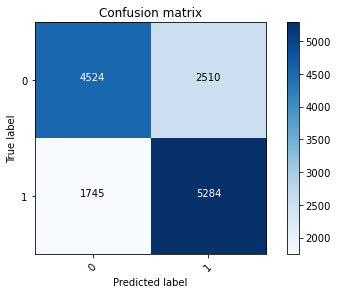

In [47]:
cm = confusion_matrix(test_data["classification"].to_numpy(), y_pred)
plot_confusion_matrix(cm, [0,1])